In [1]:
%load_ext autoreload
%autoreload 2

In [81]:
import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
from file_tools import *
import pygrib

# get some stuff set up.

omega       = ['VVEL_P0_L105_GLC0','OMEGA']
pressure    = ['PRES_P0_L105_GLC0', 'PRES']
temperature = ['TMP_P0_L105_GLC0', 'TEMP']

variables   = [omega, pressure, temperature]

# These are 45 vertical levels that the FV3 puts out - use them here to map ARW to that grid for comparison

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])
nz_new = plevels.shape[0]

_w_threshold = 5.0
_Rgas       = 287.04
_gravity    = 9.806

sw_corner = (27.776199263795622, -97.43436259615146)
ne_corner = (38.36255932569569, -81.65435850459758)

In [33]:
fv3_dir   = '/Users/Louis.Wicker/CAM_Case_Studies/2021050400/RRFS/'
fv3_files = sorted(glob.glob(fv3_dir+'/rrfs.*.nc4'))
ds_FV3 = []

for file in fv3_files:
    
    ds_FV3.append(fv3_extract_variables_over_region(file, sw_corner = sw_corner, ne_corner = ne_corner, writeout=True, prefix=None))
    print(f'Successfully created dataframe for file:  {file}\n')

------------------------------------------------------------------------------------------------------------------------ 

FV3_Extract: Extracting variables over region from input file: /Users/Louis.Wicker/CAM_Case_Studies/2021050400/RRFS/rrfs.t00z.mem01.naf018.nc4 

Creating a sub-region of DataArray: 27.78, -97.43, 38.36, -81.65 

Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/2021050400/RRFS/region.t00z.mem01.naf018.nc4 

Successfully created dataframe for file:  /Users/Louis.Wicker/CAM_Case_Studies/2021050400/RRFS/rrfs.t00z.mem01.naf018.nc4

------------------------------------------------------------------------------------------------------------------------ 

FV3_Extract: Extracting variables over region from input file: /Users/Louis.Wicker/CAM_Case_Studies/2021050400/RRFS/rrfs.t00z.mem01.naf019.nc4 

Creating a sub-region of DataArray: 27.78, -97.43, 38.36, -81.65 

Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/2021050400

In [31]:
arw_dir   = '/Users/Louis.Wicker/CAM_Case_Studies/2021050400/HRRR'
arw_files = sorted(glob.glob(arw_dir+'/hrrr.*.nc4'))

ds_WRF = []

for file in arw_files:

    tmp, outfilename = wrf_extract_variables_over_region(file, sw_corner = sw_corner, ne_corner = ne_corner, writeout=True, prefix=None)
    print(f'Successfully created dataframe for file:  {file}','\n')

    ds_WRF.append(tmp)



------------------------------------------------------------------------------------------------------------------------ 

WRF_Extract: Extracting variables over region from input file: /Users/Louis.Wicker/CAM_Case_Studies/2021050400/HRRR/hrrr.20210504_conus_hrrr.t00z.wrfnatf18.nc4 

Creating a sub-region of DataArray: 27.78, -97.43, 38.36, -81.65 

Successfully interpolated fields from file:  /Users/Louis.Wicker/CAM_Case_Studies/2021050400/HRRR/hrrr.20210504_conus_hrrr.t00z.wrfnatf18.nc4 

Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/2021050400/HRRR/region.20210504_conus_hrrr.t00z.wrfnatf18.nc4 

Successfully created dataframe for file:  /Users/Louis.Wicker/CAM_Case_Studies/2021050400/HRRR/hrrr.20210504_conus_hrrr.t00z.wrfnatf18.nc4 

------------------------------------------------------------------------------------------------------------------------ 

WRF_Extract: Extracting variables over region from input file: /Users/Louis.Wicker/CAM_Case_Studies/2

No handles with labels found to put in legend.
No handles with labels found to put in legend.


TypeError: 'Text' object is not callable

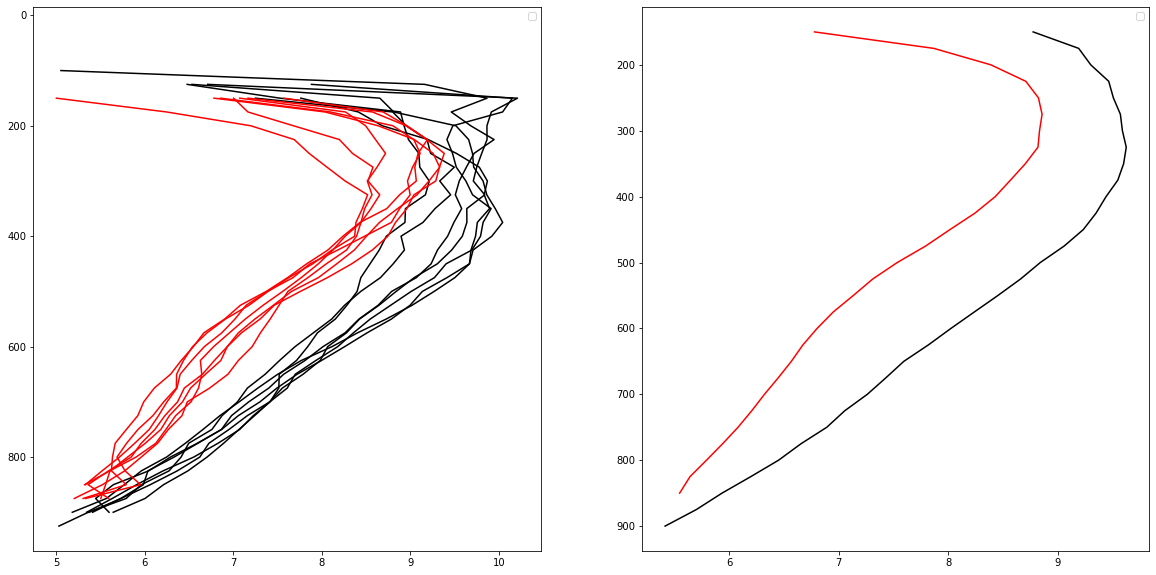

In [40]:
figsize = (20,10)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = figsize)

wrf_mean = np.zeros((7,nz_new))
fv3_mean = np.zeros((7,nz_new))

for n, item in enumerate(ds_WRF):
    dsW_WRF = item.where( item.W_interp > _w_threshold )
    dsWmean_WRF = dsW_WRF.W_interp.mean(dim=("ny","nx"), skipna=True, keep_attrs=False)
    ax1.plot(dsWmean_WRF.values, plevels/100., color='black')
    wrf_mean[n,:] = dsWmean_WRF.values

for n, item in enumerate(ds_FV3):    
    dsW_FV3 = item.where( item.W > _w_threshold )
    dsWmean_FV3 = dsW_FV3.W.mean(dim=("ny","nx"), skipna=True, keep_attrs=False)
    ax1.plot(dsWmean_FV3.values, plevels/100., color='red')
    fv3_mean[n,:] = dsWmean_FV3.values
    
ax1.invert_yaxis()
ax2.invert_yaxis()

ax2.plot(wrf_mean.mean(axis=0), plevels/100., color='black')
ax2.plot(fv3_mean.mean(axis=0), plevels/100., color='red')
ax1.legend()
ax2.legend()
ax1.set_title("Hourly WRF and FV3 Regional Udraft profiles from 18-00Z")
ax2.set_title("Average WRF and FV3 regional Udraft profiles")



In [ ]:
file = '/Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/nord3/PRSLEV.GrbF06'
fv3_grib_read_variable(file, sw_corner = sw_corner, ne_corner = ne_corner, var_list=['W'], writeout=True, prefix=None)


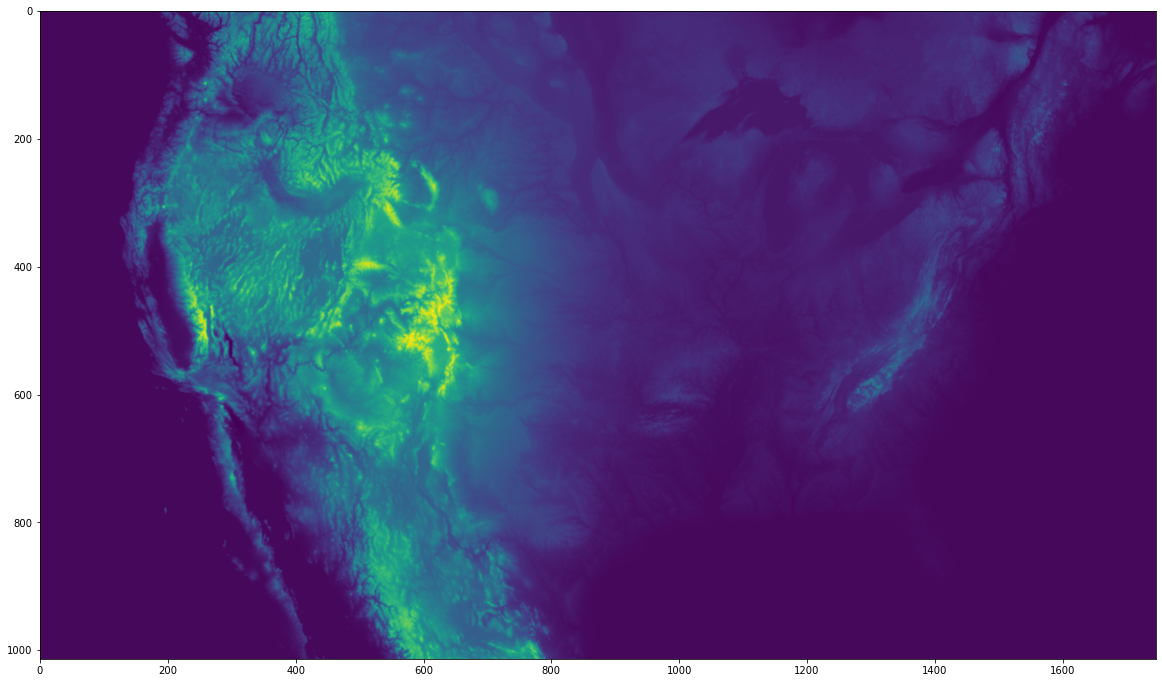

In [63]:
fig = plt.subplots(figsize = (20,20))
plt.imshow(d2d.orog[::-1,:])

In [35]:
ds.data_vars

Data variables:
    gh       (isobaricInhPa, y, x) float32 167.5 167.5 ... 4.302e+04 4.302e+04
    t        (isobaricInhPa, y, x) float32 289.4 289.4 289.4 ... 257.7 257.6
    r        (isobaricInhPa, y, x) float32 80.0 80.0 80.0 ... 0.0001 0.0001
    dpt      (isobaricInhPa, y, x) float32 285.9 285.9 285.9 ... 192.1 192.1
    q        (isobaricInhPa, y, x) float32 0.00918 0.00919 ... 5.68e-07 5.67e-07
    w        (isobaricInhPa, y, x) float32 0.082 0.091 ... 0.00195 0.001946
    wz       (isobaricInhPa, y, x) float32 -0.0132 -0.0132 ... -0.04946 -0.04946
    u        (isobaricInhPa, y, x) float32 -1.63 -1.6 -1.57 ... -4.43 -4.42
    v        (isobaricInhPa, y, x) float32 -5.29 -5.29 -5.29 ... 2.67 2.67 2.67
    tke      (isobaricInhPa, y, x) float32 nan nan nan nan ... nan nan nan nan
    clwmr    (isobaricInhPa, y, x) float32 0.0 0.0 0.0 0.0 ... 1e-12 1e-12 1e-12
    icmr     (isobaricInhPa, y, x) float32 1e-12 1e-12 1e-12 ... 1e-12 1e-12
    rwmr     (isobaricInhPa, y, x) float32 0

In [41]:
ds.wz.data.max()

18.00525

In [51]:
d3 = xr.load_dataset(file, engine="cfgrib", filter_by_keys={'typeOfLevel': 'heightAboveSea'})

skipping variable: paramId==133 shortName='q'
Traceback (most recent call last):
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/cfgrib/dataset.py", line 591, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveSea' value=Variable(dimensions=('heightAboveSea',), data=array([ 305.,  457.,  610.,  914., 1524., 1829., 2134., 2743., 3658.,
       4572.])) new_value=Variable(dimensions=(), data=305.0)


In [52]:
d3.data_vars

Data variables:
    t        (heightAboveSea, y, x) float32 288.1 288.1 288.1 ... 268.3 268.3
    u        (heightAboveSea, y, x) float32 -1.64 -1.61 -1.59 ... 22.19 22.17
    v        (heightAboveSea, y, x) float32 -5.26 -5.25 -5.25 ... -3.17 -3.22

In [64]:
txt = ('stepType': 'instant', 'typeOfLevel': 'surface')

SyntaxError: invalid syntax (2502260557.py, line 1)

[autoreload of file_tools failed: Traceback (most recent call last):
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>",